In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

import sys
sys.path.append('..')

import nsgp_vi
from nsgp_vi import nsgpVI


tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

tf.__version__

'2.6.2'

In [2]:
domain_size = 10.
# Set up the inducing grid
grid_size = 20
num_inducing_points_= grid_size*grid_size
x = np.linspace(0, domain_size, grid_size,endpoint=False)[...,np.newaxis] 
y = np.linspace(0, domain_size, grid_size,endpoint=False)[...,np.newaxis]

xx, yy = np.meshgrid(x, y, sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()])


x_grid = x_grid.T
print(x_grid.shape)

x_grid_r = x_grid.copy()
np.random.shuffle(x_grid_r)



(400, 2)


In [3]:
#Load the data
df = pd.read_csv('../data/synthetic_data/positions_b2.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values


num_training_points_ = T.shape[0]

X_x = df['Latitude'].values
X_y = df['Longitude'].values
X = np.zeros((len(X_x),2))
X[:,0] = X_x
X[:,1] = X_y

print(np.shape(X))
print(np.shape(T))
sigma = np.array(df['Sigma'].values).reshape(len(X_x),1)
beta = np.array(df['Beta'].values).reshape(len(X_x),1)

(100000, 2)
(100000, 1)


In [4]:
# create the dataset

BATCH_SIZE=4
SEG_LENGTH=500

allT = []
allX = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])

num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0])
print('..',num_training_points_,'..')

.. 100000 ..


In [5]:

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
       
        self.rand_start = np.random.randint(SEG_LENGTH)
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 

        
        jj = np.arange(self.rand_start+self.j*SEG_LENGTH,self.rand_start+(self.j+1)*SEG_LENGTH)
        jj = jj%T.shape[0]

        jj = np.sort(jj)
        TT = T[jj]
        XX = X[jj]
    
        self.j += 1
        
        if self.rand_start+(self.j*SEG_LENGTH) > T.shape[0]:
            self.i+=1
            self.rand_start = 0
            self.j=0

        return TT,XX,0.5*(XX[:-1]+XX[1:])
        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,2]))) 
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset = dataset.with_options(options)

2022-06-29 12:46:28.375916: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 12:46:35.326116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


In [6]:
import importlib
importlib.reload(nsgp_vi)

from nsgp_vi import nsgpVI

In [7]:
## set up the kernels and model
kernel_len_a = tfp.util.TransformedVariable(1.0,tfb.Softplus(),dtype=tf.float64, name='k_len_a')
kernel_amp_a = tfp.util.TransformedVariable(1.0,tfb.Softplus(), dtype=tf.float64, name='k_amp_a')

kernel_amp_l = tfp.util.TransformedVariable(1.0,tfb.Softplus(), dtype=tf.float64, name='k_amp_l')
kernel_len_l = tfp.util.TransformedVariable(1.0,tfb.Softplus(), dtype=tf.float64, name='k_len_l')

kernel_len = tfk.ExpSinSquared(kernel_len_a,kernel_len_l,period=domain_size)
kernel_amp = tfk.ExpSinSquared(kernel_amp_a,kernel_amp_l,period=domain_size)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
             inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
             segment_length = SEG_LENGTH, num_sequential_samples=1,num_parallel_samples=32,jitter=1e-8) 


2022-06-29 12:47:41.693687: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [8]:
loss,lens = vgp.optimize(BATCH_SIZE, MAX_ITERS=200,lr=0.01,threshold=0.01,window=2)#stopping_interval=5, evaluation_interval=20, stopping_threshold=0.1)


  0%|          | 0/200 [00:00<?, ?it/s]2022-06-29 12:47:49.527639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Instructions for updating:
Do not call `graph_parents`.


2022-06-29 12:47:56.111411: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 254977024 exceeds 10% of free system memory.
2022-06-29 12:48:09.300044: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 31872128 exceeds 10% of free system memory.
2022-06-29 12:48:40.965846: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x55b9500a7cf0
2022-06-29 12:49:03.864368: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 31872128 exceeds 10% of free system memory.
2022-06-29 12:49:04.134978: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 254977024 exceeds 10% of free system memory.
Loss 819.073792,  klen_l 1.086250, kamp_l 1.258478, obs 0.304684:   0%|          | 0/200 [02:44<?, ?it/s] 2022-06-29 12:50:37.919675: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 191232768 exceeds 10% of free system memory.
Loss -1110.614482,  klen_l 1.362553, kamp_l 1.058241, obs 0.00010

## Plotting

In [9]:
l = 10 # lengthscale of the domain 
k = 1 # any k 
f = k/l # k - integer

beta_max = 1.0
beta_range = 0.5

sigma_max = 0.5
sigma_range = -0.25

b = 2

def trunc_sin(v):
    return np.sqrt((1+b**2)/((1+(b**2)*(np.sin(v))**2)))*np.sin(v)

def beta_value(x,y):
    return beta_max*np.logaddexp(0,beta_range*trunc_sin(2*np.pi*f*x) * trunc_sin(2*np.pi*f*y))
    
def sigma_value(x,y):
    return sigma_max*np.logaddexp(0,sigma_range*trunc_sin(2*np.pi*f*x) * trunc_sin(2*np.pi*f*y))


In [10]:
# true values of the parameters
N=20
xp = np.linspace(0,l,N)
yp = np.linspace(0,l,N)


xx, yy = np.meshgrid(xp, yp, sparse=False)

beta_grid = np.zeros((N,N))
sigma_grid = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        beta_grid[i,j]=beta_value(xp[i],yp[j])
        sigma_grid[i,j]=sigma_value(xp[i],yp[j])


In [11]:
# Test the inferred results against the expected values by taking different slices 

#Set up a new grid consisting of a grid in x(from 0 to 10) and different values of y
num_plt = 100
x_plt = np.linspace(0, 10, num_plt)[...,np.newaxis]
y_plt = 7.5*np.ones(num_plt)[...,np.newaxis] # might change here
xx_plt, yy_plt = np.meshgrid(x_plt, y_plt, sparse=False)
x_plt_grid = np.array([xx_plt.flatten(), yy_plt.flatten()])
X_plt_grid=x_plt_grid.T[:num_plt] # take the relevant pairs that do not repeat themselves
np.shape(X_plt_grid)

(100, 2)

In [12]:
# get the true values at the slices
Beta_slice = beta_max*np.logaddexp(0,beta_range*trunc_sin(2*np.pi*f*x_plt) * trunc_sin(2*np.pi*f*y_plt))
Sigma_slice = sigma_max*np.logaddexp(0,sigma_range*trunc_sin(2*np.pi*f*x_plt) * trunc_sin(2*np.pi*f*y_plt))
true_var = (Sigma_slice**2)/(2*Beta_slice)
true_len = (1/Beta_slice)

In [13]:

len_grid_all_samples, var_grid_all_samples = vgp.get_samples(X_plt_grid[None], S=1000)

len_samples, var_samples = vgp.get_samples(x_grid[None], S=1000)

len_grid = np.mean(len_samples.numpy().reshape(-1,grid_size,grid_size),axis=0)
var_grid = np.mean(var_samples.numpy().reshape(-1,grid_size,grid_size),axis=0)

In [14]:
# for the variance parameter take percentiles to calculate the credible intervals
first_line_variance = np.percentile(var_grid_all_samples,2.5,axis=0)[0,:,0]
second_line_variance = np.percentile(var_grid_all_samples,97.5,axis=0)[0,:,0]

third_line_variance = np.percentile(var_grid_all_samples,25,axis=0)[0,:,0]
fourth_line_variance = np.percentile(var_grid_all_samples,75,axis=0)[0,:,0]

mean_variance = np.mean(var_grid_all_samples,axis = 0)[0,:,0]

# for the lengthscale parameter take percentiles to calculate the credible intervals
first_line_len = np.percentile(len_grid_all_samples,2.5,axis=0)[0,:,0]
second_line_len = np.percentile(len_grid_all_samples,97.5,axis=0)[0,:,0]

third_line_len= np.percentile(len_grid_all_samples,25,axis=0)[0,:,0]
fourth_line_len= np.percentile(len_grid_all_samples,75,axis=0)[0,:,0]

mean_len = np.mean(len_grid_all_samples,axis = 0)[0,:,0]

In [15]:

import matplotlib.ticker as tick
plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 


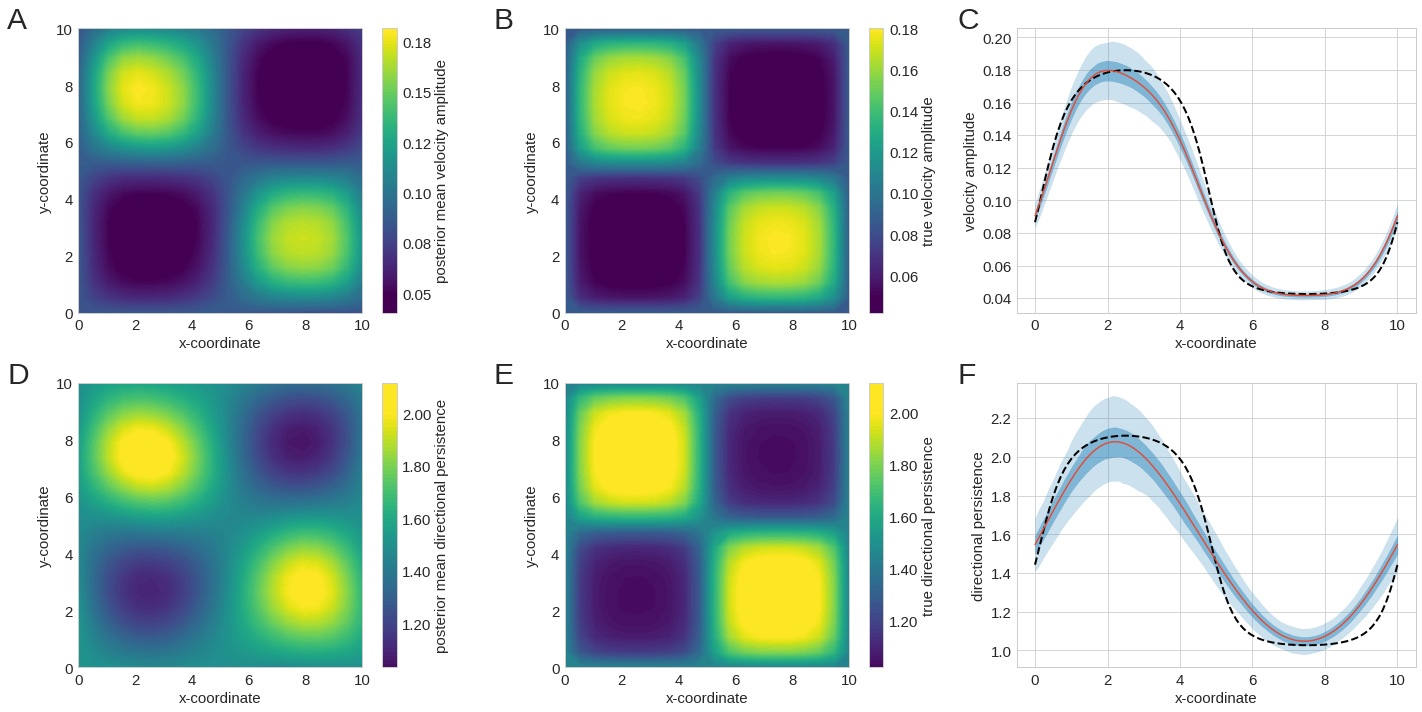

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))#,gridspec_kw={'width_ratios': [1,1,1.5]})

ax0 = axs[0, 0].contourf(xx,yy,var_grid,levels=100,cmap='viridis',vmin=0.05,vmax=0.18)
axs[0, 0].set_aspect('equal', 'box')
axs[0,0].set_xlabel('x-coordinate',size=15)
axs[0,0].set_ylabel('y-coordinate',size=15)
#axs[0,0].set_title('A',loc='center',size=30)
axs[0,0].text(-0.25,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params(axis='both', which='major', labelsize=15)
cbar = fig.colorbar(ax0, ax=axs[0, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='posterior mean velocity amplitude',size=15)
cbar.ax.tick_params(labelsize=15) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

ax01 = axs[0, 1].contourf(xx,yy,(sigma_grid**2)/(2*beta_grid),levels=100,cmap='viridis',vmin=0.05,vmax=0.18)
axs[0, 1].set_aspect('equal', 'box')
axs[0,1].set_xlabel('x-coordinate',size=15)
axs[0,1].set_ylabel('y-coordinate',size=15)
axs[0,1].text(-0.25,1,'B', size=30, transform=axs[0, 1].transAxes)
axs[0,1].tick_params(axis='both', which='major', labelsize=15)
cbar = fig.colorbar(ax01, ax=axs[0, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='true velocity amplitude',size=15)
cbar.ax.tick_params(labelsize=15) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


axs02 = axs[0, 2].plot(x_plt,true_var,color='black',lw= 2,linestyle='dashed')
axs[0, 2].fill_between(np.squeeze(x_plt),first_line_variance,second_line_variance,alpha = 0.25,color='C1')
axs[0, 2].fill_between(np.squeeze(x_plt),third_line_variance,fourth_line_variance,alpha = 0.5,color='C1')
axs[0, 2].plot(x_plt,mean_variance)
axs[0, 2].set_xlabel('x-coordinate',size=15)
axs[0, 2].set_ylabel('velocity amplitude',size=15)
axs[0,2].text(-0.15,1,'C', size=30, transform=axs[0, 2].transAxes)
axs[0,2].tick_params(axis='both', which='major', labelsize=15)



ax10 = axs[1, 0].contourf(xx,yy,len_grid,levels=100,cmap='viridis',vmin=1.0,vmax=2.0)
axs[1, 0].set_aspect('equal', 'box')
axs[1,0].set_xlabel('x-coordinate',size=15)
axs[1,0].set_ylabel('y-coordinate',size=15)
axs[1,0].text(-0.25,1,'D', size=30, transform=axs[1, 0].transAxes)
axs[1,0].tick_params(axis='both', which='major', labelsize=15)
#axs[1,0].set_title('D',loc='center',size=10)
cbar = fig.colorbar(ax10, ax=axs[1, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='posterior mean directional persistence',size=15)
cbar.ax.tick_params(labelsize=15) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



ax11 = axs[1, 1].contourf(xx,yy,beta_grid**-1,levels=100,cmap='viridis',vmin=1.0,vmax=2.0)
axs[1, 1].set_aspect('equal', 'box')
axs[1,1].set_xlabel('x-coordinate',size=15)
axs[1,1].set_ylabel('y-coordinate',size=15)
#axs[1,1].set_title('E',loc='center',size=10)
axs[1,1].text(-0.25,1,'E', size=30, transform=axs[1, 1].transAxes)
axs[1,1].tick_params(axis='both', which='major', labelsize=15)
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='true directional persistence',size=15)
cbar.ax.tick_params(labelsize=15) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()




axs[1, 2].plot(x_plt,true_len,color='black',lw= 2,linestyle='dashed')
axs[1, 2].fill_between(np.squeeze(x_plt),first_line_len,second_line_len,alpha = 0.25,color='C1')
axs[1, 2].fill_between(np.squeeze(x_plt),third_line_len,fourth_line_len,alpha = 0.5,color='C1')
axs[1, 2].plot(x_plt,mean_len)
axs[1, 2].set_xlabel('x-coordinate',size=15)
axs[1, 2].set_ylabel('directional persistence',size=15)
#axs[1, 2].set_title('F',loc='center',size=10)
axs[1,2].text(-0.15,1,'F', size=30, transform=axs[1, 2].transAxes)
#axs[1,2].set_xticklabels(fontsize=10)
axs[1,2].tick_params(axis='both', which='major', labelsize=15)


fig.tight_layout()


plt.savefig("inference_synthetic_environment.png",dpi=300)
plt.show()








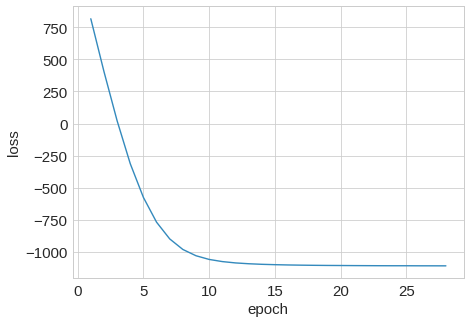

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax0 = plt.subplots(1, 1, figsize=(7,5))#,gridspec_kw={'width_ratios': [1,1,1.5]})
ax0.plot(1+np.arange(len(loss)),loss[0:],'-',c='C1')



ax0.set_xlabel('epoch',size=15)
ax0.set_ylabel('loss',size=15)
ax0.tick_params(axis='both', which='major', labelsize=15)
# ax0.set_xlim(-1,200)

# ax1 = inset_axes(ax0, width="50%", height="50%", loc=1)
# ax1.plot(np.arange(25,200),loss[25:],'-',c='C1')


# ax1.set_xlabel('epoch',size=15)
# ax1.set_ylabel('loss',size=15)
# ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.set_xlim(24,200)


plt.savefig("synthetic_training_loss.png",dpi=300)

plt.show()